In [15]:
import os
import os.path as osp
root_dir = osp.dirname(osp.dirname(os.getcwd()))

import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
plt.rc('axes', axisbelow=True)
plt.rcParams.update({'figure.autolayout': True})

ram_dir = osp.join(root_dir, 'experiments', 'all_lysates', 'thesis-rerun', '1-graph', 'ram')
ram_files = [f for f in os.listdir(ram_dir) if '.npy' in f]

species2idx = {
    "Oleispira antarctica": 0,
    "Caenorhabditis elegans": 1,
    "Arabidopsis thaliana": 2,
    "Drosophila melanogaster": 3,
    "Danio rerio": 4,
    "Saccharomyces cerevisiae": 5,
    "Bacillus subtilis": 6,
    "Escherichia coli": 7,
    "Homo sapiens": 8,
    "Mus musculus": 9,
    "Geobacillus stearothermophilus": 10,
    "Picrophilus torridus": 11,
    "Thermus thermophilus": 12
}
cm = plt.get_cmap('gist_rainbow')

edge_types = ['pae', 'contact', 'backbone', 'codir', 'coord', 'deform']

In [2]:
meta_file = osp.join(root_dir, 'data', 'collation', 'DeepSTABp', 'lysate.csv')

meta = np.loadtxt(meta_file, skiprows=1, delimiter=',', dtype=np.str_)
print(meta)

meta_accessions = meta[:,0]
meta_Tm = meta[:,1].astype(np.float_)
meta_ogts = meta[:,2].astype(np.float_)
meta_species = meta[:,3]

# accession_groups = []
# for ogt in np.unique(ogts):
#     accession_groups.append(accessions[ogts == ogt])

[['A0A023PXQ4' '52.4077619837866' '32.0' 'Saccharomyces cerevisiae']
 ['A0A023T4K3' '37.96367254303041' '20.0' 'Caenorhabditis elegans']
 ['A0A023T778' '54.99367375656585' '37.0' 'Mus musculus']
 ...
 ['Z4YL87' '54.9920512273696' '37.0' 'Mus musculus']
 ['Z4YLI8' '48.64740428630003' '37.0' 'Mus musculus']
 ['Z4YML9' '53.356698003754886' '37.0' 'Mus musculus']]


In [3]:
test = False
save = True

In [4]:
# sum statistics

sum_stats = np.empty((7, len(ram_files)))
accessions = []
species = []
tms = []

pbar = tqdm(ram_files)
for i, ram_file in enumerate(pbar):
    pbar.set_description(ram_file)
    if test and i > 5:
        break

    accession = ram_file.split('-')[0]
    accessions.append(accession)
    species.append(meta_species[meta_accessions==accession][0])
    tms.append(meta_Tm[meta_accessions==accession][0])

    # load data
    ram_path = os.path.join(ram_dir, ram_file)
    ram = np.load(ram_path)

    # remove negative values
    ram_abs = np.abs(ram)

    # sum RAM on all edge types
    ram_sum = np.vstack((ram_abs, np.sum(ram_abs, axis=0)))

    # sum of ramper residue
    sum_stats[:,i] = np.mean(ram_sum, axis=1)

accessions = np.array(accessions)
species = np.array(species)
tms = np.array(tms)

  0%|          | 0/20255 [00:00<?, ?it/s]

In [5]:
norm_sumstats = sum_stats/sum_stats[[-1],:] * 100

avg = np.mean(norm_sumstats, axis=1)
std = np.std(norm_sumstats, axis=1)
max_val = np.max(norm_sumstats, axis=1)
min_val = np.min(norm_sumstats, axis=1)
mid = np.median(norm_sumstats, axis=1)

for i, edge_type in enumerate(edge_types + ['all']):
    print(f'{edge_type:8s}\t{avg[i]:>8.4f}\t{std[i]:>8.4f}\t{max_val[i]:>8.4f}\t{min_val[i]:>8.4f}\t{mid[i]:>8.4f}')

pae     	 12.4743	 11.6425	 71.4375	  0.0075	  9.3400
contact 	  5.5186	  4.9636	 64.6656	  0.0383	  4.2258
backbone	 15.9524	  9.4154	 78.3164	  1.0781	 13.8623
codir   	 17.8981	 16.0300	 92.6836	  0.1392	 13.5281
coord   	 17.4569	 11.6599	 70.3744	  0.6422	 15.0180
deform  	 30.6996	 14.5122	 81.9221	  0.7548	 29.0672
all     	100.0000	  0.0000	100.0000	100.0000	100.0000


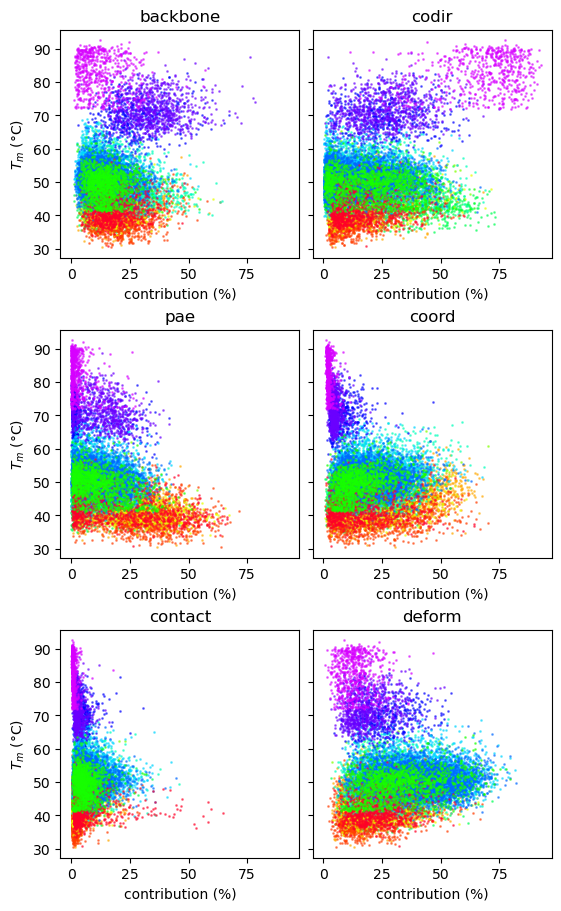

In [16]:
# scatter: RAM percent vs Tm

fig, ax = plt.subplots(
    3, 2, sharex=True, sharey=True, figsize=(5.5,9), layout='compressed'
)
ax = ax.flatten()

for i, edge_type in enumerate(['backbone', 'codir', 'pae', 'coord', 'contact', 'deform']):

    for s in np.unique(species):
        ax[i].scatter(
            norm_sumstats[edge_types.index(edge_type)][species==s],
            tms[species==s],
            color=cm(species2idx[s]/len(species2idx)),
            s=1,
            alpha=0.5
        )
    
    ax[i].set_title(edge_type)

    ax[i].set_xlabel('contribution (%)')
    ax[i].tick_params(labelbottom=True)
    if i%2 == 0:
        ax[i].set_ylabel(r'$T_m$ (°C)')

if save:
    plt.savefig('RAM_percentage_vs_Tm.png', dpi=300)#, bbox_inches='tight')
plt.show()
plt.close()

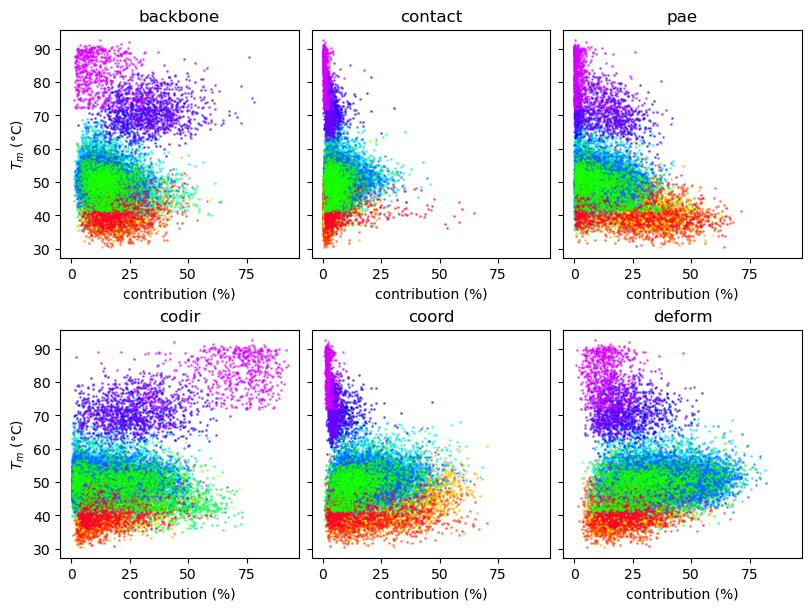

In [17]:
# scatter: RAM percent vs Tm

fig, ax = plt.subplots(
    2, 3, sharex=True, sharey=True, figsize=(8,6), layout='compressed'
)
ax = ax.flatten()

for i, edge_type in enumerate(['backbone', 'contact', 'pae', 'codir', 'coord', 'deform']):

    for s in np.unique(species):
        ax[i].scatter(
            norm_sumstats[edge_types.index(edge_type)][species==s],
            tms[species==s],
            color=cm(species2idx[s]/len(species2idx)),
            s=1,
            alpha=0.5
        )
    
    ax[i].set_title(edge_type)

    ax[i].set_xlabel('contribution (%)')
    ax[i].tick_params(labelbottom=True)
    if i%3 == 0:
        ax[i].set_ylabel(r'$T_m$ (°C)')

if save:
    plt.savefig('RAM_percentage_vs_Tm-horizontal.png', dpi=300)
plt.show()
plt.close()

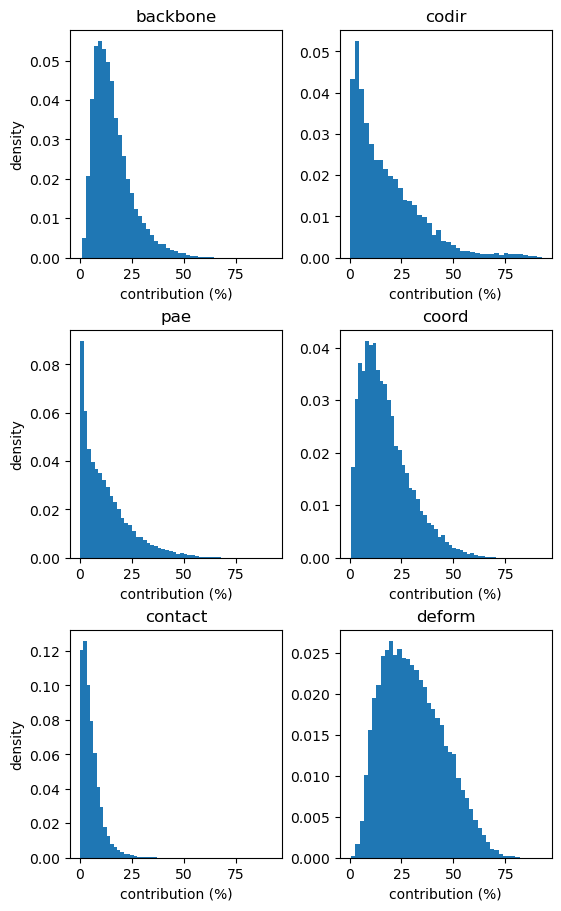

In [18]:
# histogram 

fig, ax = plt.subplots(
    3, 2, sharex=True, sharey=False, figsize=(5.5,9), layout='compressed'
)
ax = ax.flatten()

for i, edge_type in enumerate(['backbone', 'codir', 'pae', 'coord', 'contact', 'deform']):

    ax[i].set_title(edge_type)

    ax[i].hist(norm_sumstats[edge_types.index(edge_type),:], bins=40, density=True)
    ax[i].set_xlabel('contribution (%)')
    ax[i].tick_params(labelbottom=True)
    if i%2 == 0:
        ax[i].set_ylabel('density')
    # ax[i].grid()

if save:
    plt.savefig('hist-RAM_contribution.png', dpi=300)
plt.show()
plt.close()

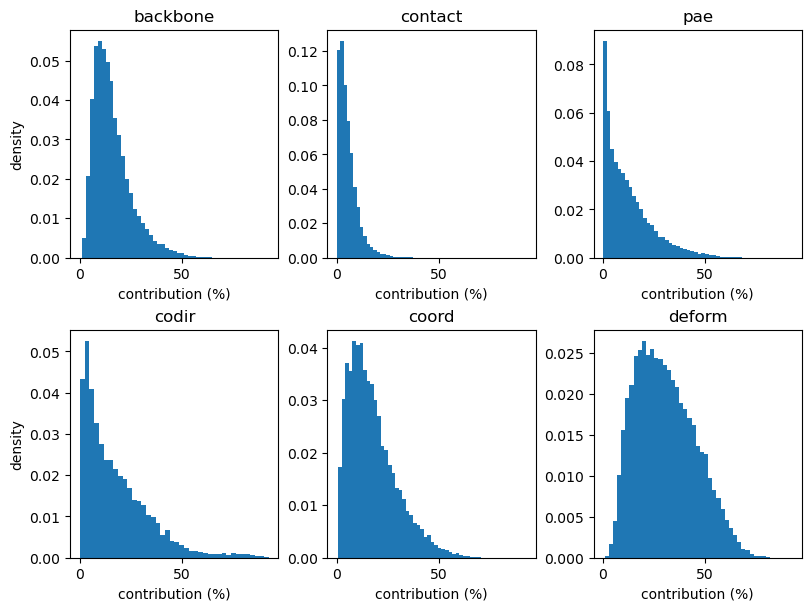

In [19]:
# histogram 

fig, ax = plt.subplots(
    2, 3, sharex=True, sharey=False, figsize=(8,6), layout='compressed'
)
ax = ax.flatten()

for i, edge_type in enumerate(['backbone', 'contact', 'pae', 'codir', 'coord', 'deform']):

    ax[i].set_title(edge_type)

    ax[i].hist(norm_sumstats[edge_types.index(edge_type),:], bins=40, density=True)
    ax[i].set_xlabel('contribution (%)')
    ax[i].tick_params(labelbottom=True)
    if i%3 == 0:
        ax[i].set_ylabel('density')
    # ax[i].grid()

if save:
    plt.savefig('hist-RAM_contribution-horizontal.png', dpi=300)
plt.show()
plt.close()

In [ ]:
for i, ram_file in enumerate(os.listdir(ram_dir)):
    if test and i > 5:
        break

    print(ram_file)

    accession = ram_file.split('-')[0]

    ram_path = os.path.join(ram_dir, ram_file)
    ram = np.load(ram_path)

    fig, ax = plt.subplots(
        7, 1, sharex=True, sharey=True, figsize=(5.5, 9), layout='constrained' 
    )
    ax = ax.flatten()
    fig.suptitle(accession)

    n_res = ram.shape[1]
    res_idx = np.arange(n_res)

    y_abs_max = 0

    for i, edge_type in enumerate(['pae', 'contact', 'backbone', 'codir', 'coord', 'deform']):

        # ax[i].plot(np.where(ram[edge_types.index(edge_type)]>0, ram[edge_types.index(edge_type)], 0), linewidth=0.8)
        ax[i].bar(res_idx, np.where(ram[edge_types.index(edge_type)]>0, ram[edge_types.index(edge_type)], 0))

        ax[i].bar(res_idx, np.where(ram[edge_types.index(edge_type)]>0, ram[edge_types.index(edge_type)], 0), color='blue')
        ax[i].bar(res_idx, np.where(ram[edge_types.index(edge_type)]<0, ram[edge_types.index(edge_type)], 0), color='red')

        ax[i].axhline(y=0, c='gray', linewidth=0.5)

        ax[i].set_title(edge_type)

        ax[i].set_xlabel('residue')
        ax[i].set_ylabel('ram')
    
        # ax[i].set_xlim(0, ram[edge_types.index(edge_type)].size)
        y_abs_max = max(y_abs_max, np.abs(ram[edge_types.index(edge_type)]).max())

    i += 1
    ram_sum = np.sum(ram, axis=0)
    y_abs_max = max(y_abs_max, np.abs(ram_sum).max())

    # ax[i].plot(np.where(ram_sum>0, ram_sum, 0), linewidth=0.8)
    ax[i].bar(res_idx, np.where(ram_sum>0, ram_sum, 0))

    ax[i].bar(res_idx, np.where(ram_sum>0, ram_sum, 0), color='blue')
    ax[i].bar(res_idx, np.where(ram_sum<0, ram_sum, 0), color='red')

    ax[i].axhline(y=0, c='gray', linewidth=0.5)

    ax[i].set_title('Overall')

    ax[i].set_xlabel('residue')
    ax[i].set_ylabel('ram')

    ax[i].set_xlim(0, ram_sum.size)
    ax[i].set_ylim(-y_abs_max, y_abs_max)

    if save:
        plt.savefig(f'save/ram-{accession}.png', dpi=300)
    plt.show()
    plt.close()
    
    # break